# Model Selection

In [1]:
from os import chdir
chdir('../')
%matplotlib inline
from lib import *

In [2]:
pwd

'/home/jovyan/work/projects/project_2'

### Load Data

In [3]:
#  data
features = pd.DataFrame(pd.read_pickle('./pickled/pickled_features'))
target = pd.DataFrame(pd.read_pickle('./pickled/pickled_target'))

# deskewed data
features_deskewed = pd.DataFrame(pd.read_pickle('./pickled/pickled_features_deskewed'))
target_deskewed = pd.DataFrame(pd.read_pickle('./pickled/pickled_target_deskewed'))

In [4]:
features.head(5)

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.0,60.0,65.0,8450.0,2003.0,2003.0,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,2.0,20.0,80.0,9600.0,1976.0,1976.0,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,3.0,60.0,68.0,11250.0,2001.0,2002.0,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,4.0,70.0,60.0,9550.0,1915.0,1970.0,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,5.0,60.0,84.0,14260.0,2000.0,2000.0,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [5]:
features_deskewed.head()

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.8918,4.6821,9.0707,5.2883,6.8395,0.6931,6.2615,7.8482,6.6619,6.7523,...,0,0,0,1,0,0,0,0,1,0
1,2.1972,4.8122,9.1949,0.6931,7.0951,0.6931,6.4892,7.9953,7.0800,0.6931,...,0,0,0,1,0,0,0,0,1,0
2,3.8918,4.7095,9.3498,5.0999,6.5709,0.6931,6.6946,7.8728,6.7405,6.7662,...,0,0,0,1,0,0,0,0,1,0
3,4.0775,4.6347,9.1898,0.6931,6.0958,0.6931,6.8178,7.8083,6.7878,6.6307,...,0,0,0,1,1,0,0,0,0,0
4,3.8918,4.8442,9.5824,5.8636,6.7833,0.6931,6.7616,7.9551,6.9763,6.9613,...,0,0,0,1,0,0,0,0,1,0


### (Fuction) Train-Test Split & Modeling

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
import pandas as pd
import numpy as np

def split(feature, target, test_size=.3, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(feature,target,
                                                   test_size = test_size,
                                                   random_state = random_state)
    data_dict = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
    }
    return data_dict

def transform(data_dict, transformer = StandardScaler()):
    feature=data_dict.copy()
    feature['X_train']=transformer.fit_transform(feature['X_train'])
    feature['X_test']=transformer.transform(feature['X_test'])
    
    try:
        feature['transformer'].append(transformer)
    except:
        feature['transformer']=[transformer]
    return feature   

def fit_and_score(data_dict,model):
    d=data_dict.copy()
    model.fit(d['X_train'],d['y_train'])
    train_score=model.score(d['X_train'],d['y_train'])
    test_score=model.score(d['X_test'],d['y_test'])
    try:
        d['cv_results'] = model.cv_results_
        d['best_estimator'] = model.best_estimator_
    except:
        pass
    d['model']=model
    d['train_score']= train_score
    d['test_score']=test_score
    
    return d

In [34]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, features_deskewed, target_deskewed,scoring="neg_mean_squared_error", cv = 5,n_jobs=-1))
    return(rmse)

### Benchmarking Model   Linear Regression

In [119]:
split_data = split(features, np.ravel(target))
scaled_data = transform(split_data)
lasso_results = fit_and_score(scaled_data,Lasso(alpha=10))
ridge_results = fit_and_score(scaled_data,Ridge(alpha=.001))
print('Benchmark Train Score for Lasso:', lasso_results['train_score'])
print('Benchmark Test Score for Lasso:', lasso_results['test_score'])
print('\nBenchmark Train Score for Ridge:', ridge_results['train_score'])
print('Benchmark Test Score for Ridge:', ridge_results['test_score'])

Benchmark Train Score for Lasso: 0.950533609429
Benchmark Test Score for Lasso: 0.881183194049

Benchmark Train Score for Ridge: 0.950563602152
Benchmark Test Score for Ridge: 0.875844107403


/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Cross Validation

In [87]:
## Ridge
split_data = split(features_deskewed, target_deskewed)
ridge_cv = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(features_deskewed, target_deskewed)

In [81]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


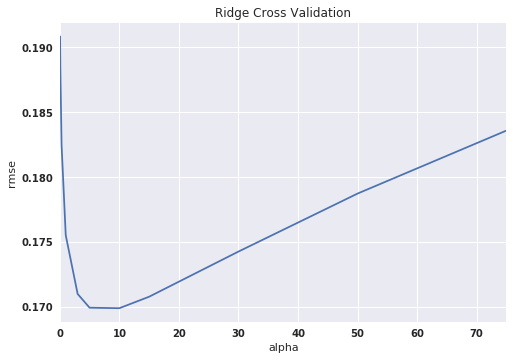

In [82]:
cv_ridge_rmse = pd.Series(cv_ridge, index = alphas)
cv_ridge_rmse.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


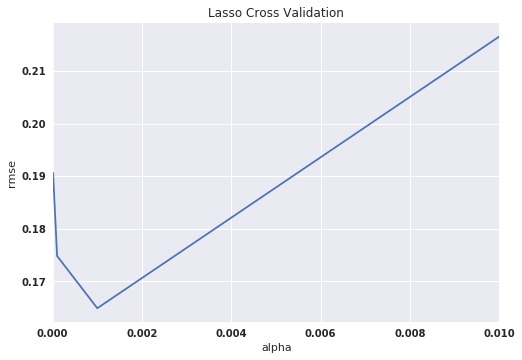

In [86]:
alphas = [0.00001, 0.0001, .001, .01]
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
cv_lasso_rmse = pd.Series(cv_lasso, index = alphas)
cv_lasso_rmse.plot(title = "Lasso Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [84]:
cv_ridge_rmse.min()

0.16989407236739643

In [85]:
cv_lasso_rmse.min()

0.16484331738461602

In [129]:
coef_neg = pd.Series(ridge_cv.coef_[0], index = features_deskewed.columns).sort_values(ascending = True).head(10)
coef_pos = pd.Series(ridge_cv.coef_[0], index = features_deskewed.columns).sort_values(ascending = True).tail(10)
print(coef_pos,"\n\n",coef_neg)

MSZoning_RH             0.1077
MSZoning_FV             0.1085
OverallQual_8           0.1113
Functional_Typ          0.1144
Neighborhood_Crawfor    0.1178
Neighborhood_StoneBr    0.1182
OverallCond_9           0.1241
OverallQual_9           0.1554
1stFlrSF                0.1599
GrLivArea               0.3161
dtype: float64 

 MSZoning_C (all)       -0.3548
RoofMatl_ClyTile       -0.1748
PoolArea_480           -0.1748
OverallCond_3          -0.1698
Condition2_PosN        -0.1399
OverallQual_3          -0.1372
Heating_Grav           -0.1357
Functional_Maj2        -0.1350
Neighborhood_MeadowV   -0.1080
Fireplaces_3           -0.1040
dtype: float64


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


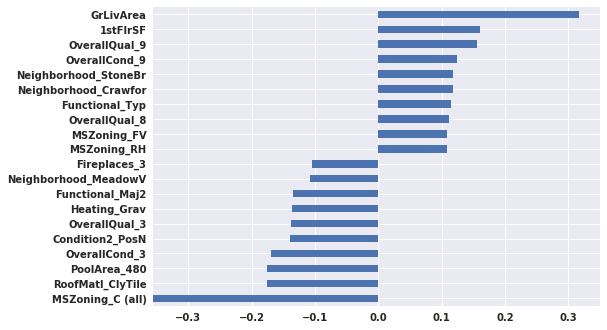

In [130]:
coef_all = pd.concat([coef_neg,coef_pos])
coef_all.plot(kind='barh')